Desicion Tree Model for ML challenge

In [ ]:
# imports
import sys
import csv
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re

In [ ]:
# Helper functions
random_state = 42


def to_numeric(s):
  """Converts string `s` to a float.
  Invalid strings and NaN values will be converted to float('nan').
  """
  if isinstance(s, str):
    s = s.replace(",", '')
    s = pd.to_numeric(s, errors="coerce")
  return float(s)


def get_number_list(s):
  """Get a list of integers contained in string `s`
  """
  return [int(n) for n in re.findall("(\d+)", str(s))]


def get_number_list_clean(s):
  """Return a clean list of numbers contained in `s`.
  Additional cleaning includes removing numbers that are not of interest
  and standardizing return list size.
  """
  n_list = get_number_list(s)
  n_list += [-1]*(6-len(n_list))
  return n_list


def get_number(s):
  """Get the first number contained in string `s`.
  If `s` does not contain any numbers, return -1.
  """
  n_list = get_number_list(s)
  return n_list[0] if len(n_list) >= 1 else -1


def find_area_at_rank(l, i):
  """Return the area at a certain rank in list `l`.
  Areas are indexed starting at 1 as ordered in the survey.
  If area is not present in `l`, return -1.
  """
  return l.index(i) + 1 if i in l else -1


def cat_in_s(s, cat):
  """Return if a category is present in string `s` as an binary integer.
  """
  return int(cat in s) if not pd.isna(s) else 0


def clean_text(s: str) -> str:
  """Convert words to lower case, remove punctuations
  """
  if not isinstance(s, str):
      return ""
  v = set('abcdefghijklmnopqrstuvwxyz ')
  out = ""
  for char in s:
      if char.lower() in v:
          out += char.lower()
  return out


In [ ]:
def parse_data(filename):
    df = pd.read_csv(filename)

    # Clean numerics
    df["Q7"] = df["Q7"].apply(to_numeric).fillna(0)
    df["Q8"] = df["Q8"].apply(to_numeric).fillna(0)
    df["Q9"] = df["Q9"].apply(to_numeric).fillna(0)


    # Clean for number categories
    df["Q1"] = df["Q1"].apply(get_number)
    df["Q2"] = df["Q2"].apply(get_number)
    df["Q3"] = df["Q3"].apply(get_number)
    df["Q4"] = df["Q4"].apply(get_number)


    # Create area rank categories
    df["Q6"] = df["Q6"].apply(get_number_list_clean)
    temp_names = []

    for idx, cat in enumerate(['Skyscrapers', 'Sport', 'Art and Music', 'Carnival', 'Cuisine',
            'Economic']):
        cat_name = f"Q6{cat}"
        temp_names.append(cat_name)
        df[cat_name] = df['Q6'].apply(lambda s: get_number_list(s)[idx])

    del df["Q6"]

    # Create category indicators
    new_names = ["Q1", "Q2", "Q3", "Q4"] + temp_names


    # Create multi-category indicators
    for cat in ["Partner", "Friends", "Siblings", "Co-worker"]:
      cat_name = f"Q5{cat}"
      new_names.append(cat_name)
      df[cat_name] = df["Q5"].apply(lambda s: cat_in_s(s, cat))
    del df["Q5"]

    df = df[new_names + ["Q7", "Q8", "Q9", "Q10", "Label"]]
    return df

In [ ]:
def build_bow_probs(df):
    vocab_set = set()
    for line in df["Q10"]:
        line = clean_text(line)
        line = line.split()
        for word in line:
          vocab_set.add(word)
    vocab = list(vocab_set)

    data = np.array(df["Q10"])
    X = np.zeros([len(data), len(vocab)])
    t = np.array(pd.get_dummies(df["Label"].values))

    for i in range(len(data)):
        review = clean_text(data[i])
        review = review.split()
        for word in review:
          j = vocab.index(word)
          X[i,j] = 1

    N, vocab_size = X.shape[0], X.shape[1]
    pi = np.sum(t)/N
    theta = np.zeros([vocab_size, 4])

    X_dub = X[t[:, 0] == 1]
    X_rio = X[t[:, 1] == 1]
    X_nyc = X[t[:, 2] == 1]
    X_par = X[t[:, 3] == 1]

    theta[:, 0] = np.sum(X_dub, axis=0) / X_dub.shape[0]
    theta[:, 1] = np.sum(X_rio, axis=0) / X_rio.shape[0]
    theta[:, 2] = np.sum(X_nyc, axis=0) / X_nyc.shape[0]
    theta[:, 3] = np.sum(X_par, axis=0) / X_par.shape[0]
    return X, pi, theta, vocab


def quote_matrix(X, pi, theta):
    eps = 1e-10

    X_complement = 1 - X
    theta_complement = 1 - theta

    prob_dub = X * theta[:,0] + X_complement * theta_complement[:,0]
    prob_rio = X * theta[:,1] + X_complement * theta_complement[:,1]
    prob_nyc = X * theta[:,2] + X_complement * theta_complement[:,2]
    prob_par = X * theta[:,3] + X_complement * theta_complement[:,3]

    exp_dub = np.exp(np.sum(np.log(prob_dub + eps), axis = 1))
    exp_rio = np.exp(np.sum(np.log(prob_rio + eps), axis = 1))
    exp_nyc = np.exp(np.sum(np.log(prob_nyc + eps), axis = 1))
    exp_par = np.exp(np.sum(np.log(prob_par + eps), axis = 1))

    probabilities = np.column_stack([exp_dub, exp_rio, exp_nyc, exp_par])
    return probabilities


def get_quote_bow(X, vocab):
    x = np.zeros([X.shape[0], len(vocab)])
    for i in range(len(X)):
      quote = clean_text(X[i][-1]).split()
      for word in quote:
          if word in vocab:
              x[i, vocab.index(word)] = 1
    return x

In [ ]:
df = parse_data("train_dataset.csv")

# Prepare data for training
df = df.sample(frac=1, random_state=random_state)
feature_names = df.columns.tolist()
feature_names.pop()
feature_names.pop()
feature_names.extend(["Q_Dub", "Q_Rio", "Q_Nyc", "Q_Par"])

X_train, pi, theta, vocab = build_bow_probs(df)
q10 = quote_matrix(X_train, pi, theta)
# del df["Q10"]

x_train = np.array(df.drop("Label", axis=1).values)
t_train = np.array(pd.get_dummies(df["Label"].values))


val_df = parse_data("val_dataset.csv")
x_valid = np.array(val_df.drop("Label", axis=1).values)
t_valid = np.array(pd.get_dummies(val_df["Label"].values))

x_train = np.concatenate((np.delete(x_train, -1 ,1), q10), axis=1)
x_valid = np.concatenate((np.delete(x_valid, -1, 1), quote_matrix(get_quote_bow(x_valid, vocab), pi, theta)), axis=1)

Start off by using Sklearn to create a decision tree model, to see what to aim for and how well it performs with our data.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

# imports to visualize tree
from sklearn import tree as treeViz
import graphviz
import pydotplus
from IPython.display import display


def visualize_tree(model, max_depth=5):
    """
    Generate and return an image representing an Sklearn decision tree.

    Each node in the visualization represents a node in the decision tree.
    In addition, visualization for each node contains:
        - The feature that is split on
        - The entropy (of the outputs `t`) at the node
        - The number of training samples at the node
        - The number of training samples with true/false values
        - The majority class (heart disease or not)
    The colour of the node also shows the majority class and purity

    See here: https://scikit-learn.org/stable/modules/generated/sklearn.tree.export_graphviz.html

    Parameters:
        `model` - An Sklearn decision tree model
        `max_depth` - Max depth of decision tree to be rendered in the notebook.
         This is useful since the tree can get very large if the max_depth is
         set too high and thus making the resulting figure difficult to interpret.
    """
    dot_data = treeViz.export_graphviz(model,
                                       feature_names=feature_names,
                                       max_depth=max_depth,
                                       class_names=["Dubai", "Rio de Janeiro", "New York City", "Paris"],
                                       filled=True,
                                       rounded=True)
    return display(graphviz.Source(dot_data))

Training Accuracy: 0.9238013698630136
Validation Accuracy: 0.8133333333333334


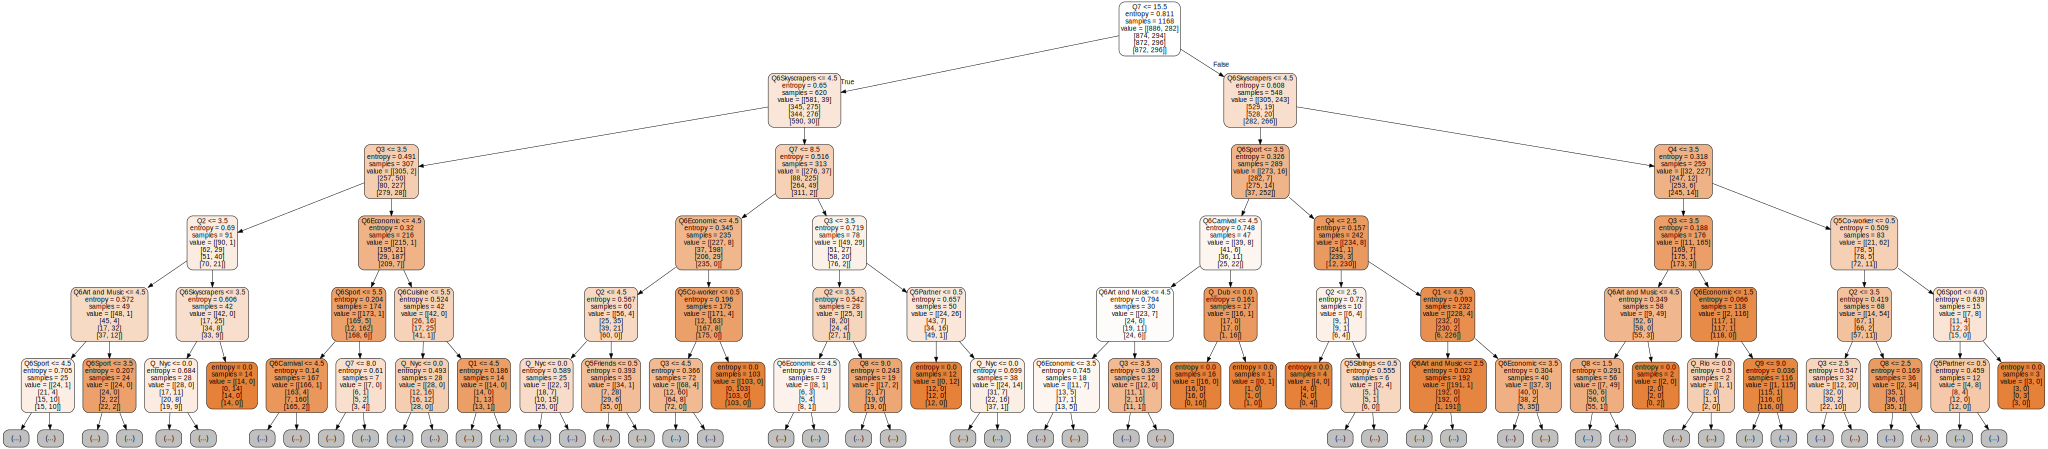

In [ ]:
# Creating a DecisionTreeClassifier
tree = DecisionTreeClassifier(criterion="entropy", max_depth=7)

# TODO: fit it to our data
tree.fit(x_train, t_train)

# Print the training and validation scores (accuracy)
print("Training Accuracy:", tree.score(x_train, t_train))
print("Validation Accuracy:", tree.score(x_valid, t_valid))
visualize_tree(tree)

Custom decision tree model

In [ ]:
class Feature:
    def __init__(self, feature_name, column, value):
        self.name = feature_name
        self.column = column
        self.value = value

    def compare(self, row):
        val = row[self.column]
        return val >= self.value


class Node:
    def __init__(self, x, t, feature, isLeaf):
      self.feature = feature
      self.left = None
      self.right = None
      self.isLeaf = isLeaf
      self.prediction = np.argmax(np.sum(t, axis=0))

    def get_feature(self):
      return self.feature


def entropy(t):
    eps = 1e-10

    probabilities = np.sum(t, axis=0) / (len(t) + eps)
    entropy_value = -np.sum(probabilities * np.log2(probabilities + eps))
    return entropy_value


def information_gain(t, splits):
    total_entropy = entropy(t)
    subset_entropy = np.sum([(len(subset) / len(t)) * entropy(subset) for subset in splits])
    information_gain_value = total_entropy - subset_entropy
    return information_gain_value


def best_split(x, t):
    best_feature = None
    best_ig = float("-inf")
    best_left = None
    best_right = None
    for i in range(len(feature_names)):

      values = set([row[i] for row in x])
      for val in values:
        feature = Feature(feature_names[i], i, val)
        split_indices = np.apply_along_axis(feature.compare, axis=1, arr=x)
        x_true = x[split_indices].copy()
        t_true = t[split_indices].copy()
        x_false = x[~split_indices].copy()
        t_false = t[~split_indices].copy()

        ig = information_gain(t, [t_true, t_false])
        if ig >= best_ig:
          best_feature = feature
          best_left = (x_true.copy(), t_true.copy())
          best_right = (x_false.copy(), t_false.copy())
          best_ig = ig
    return (best_left, best_right, best_feature)



def build_tree(x, t, max_depth):
    if max_depth == 1:
      return Node(x, t, None, True)
    else:
      max_depth -= 1
      left_split, right_split, feature = best_split(x, t)
      if left_split is None and right_split is None:
        node = Node(x, t, None, True)
        return node
      else:
        node = Node(x, t, feature, False)
        node.left = build_tree(left_split[0], left_split[1], max_depth)
        node.right = build_tree(right_split[0], right_split[1], max_depth)
        return node

In [ ]:
def pred(row, node):
    if node.isLeaf:
        return node.prediction

    if node.feature.compare(row):
        return pred(row, node.left)
    else:
        return pred(row, node.right)


def compute_accuracy(x, t, tree):
  num_correct = 0
  total = len(x)
  for i in range(total):
    prediction = pred(x[i], tree)
    if t[i][prediction] == 1:
      num_correct += 1
  return num_correct/total

In [ ]:
# Test different depths
for i in range(10):
  tree = build_tree(x_train, t_train, i + 1)
  print("Max Depth:", i + 1)
  print("Training Accuracy:", compute_accuracy(x_train, t_train, tree))
  print("Validation Accuracy:", compute_accuracy(x_valid, t_valid, tree))

Max Depth: 1
Training Accuracy: 0.2534246575342466
Validation Accuracy: 0.23666666666666666
Max Depth: 2
Training Accuracy: 0.464041095890411
Validation Accuracy: 0.4166666666666667
Max Depth: 3
Training Accuracy: 0.8253424657534246
Validation Accuracy: 0.7366666666666667
Max Depth: 4
Training Accuracy: 0.8595890410958904
Validation Accuracy: 0.76
Max Depth: 5
Training Accuracy: 0.886986301369863
Validation Accuracy: 0.77
Max Depth: 6
Training Accuracy: 0.9332191780821918
Validation Accuracy: 0.78
Max Depth: 7
Training Accuracy: 0.9751712328767124
Validation Accuracy: 0.79
Max Depth: 8
Training Accuracy: 0.9914383561643836
Validation Accuracy: 0.79
Max Depth: 9
Training Accuracy: 0.9948630136986302
Validation Accuracy: 0.79
Max Depth: 10
Training Accuracy: 0.9965753424657534
Validation Accuracy: 0.7966666666666666


In [ ]:
# Final model
tree = build_tree(x_train, t_train, 7)
print("Testing Accuracy:", compute_accuracy(x_valid, t_valid, tree))

Testing Accuracy: 0.79
